[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

---
# Setup Data

## Load & Display Data
[Kaggle Dataset](https://www.kaggle.com/ntnu-testimon/paysim1 "Synthetic Financial Datasets For Fraud Detection")

In [2]:
df = pd.read_csv('data/card.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Check Value Type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Define Each Feature

### We have 11 initial features:

* **step:** Maps a unit of time in the real world. In this case 1 step is 1 hour of time, 743 is the end of the month
* **type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
* **amount:** amount of the transaction in local currency _(may be bigger then the account balance)_
* **nameOrig:** customer who started the transaction _(start with C for customer)_
* **oldbalanceOrg:** initial balance before the transaction _(at least 0)_
* **newbalanceOrig:** customer's balance after the transaction. _(at least 0)_
* **nameDest:** recipient ID of the transaction. _(start with C for customer)_
* **oldbalanceDest:** initial recipient balance before the transaction. _(at least 0)_
* **newbalanceDest:** recipient's balance after the transaction. _(at least 0)_
* **isFraud:** identifies a fraudulent transaction (1) and non fraudulent (0)
* **isFlaggedFraud:** flags illegal attempts to transfer more than 200.000 in a single transaction.

---
# Clear Data

## Check for Null

### since the data is synthetic there are no null values
#### (as shown bellow)

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Understand The Data & Trends

### Transaction Types

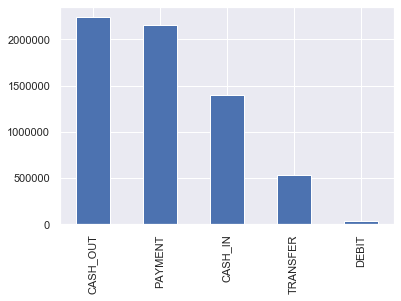

In [5]:
df['type'].value_counts().plot.bar()
plt.show()

In [6]:
precent = df['type'].value_counts(normalize=True)['DEBIT']*100
lines = df[df['type'] == 'DEBIT']['type'].value_counts()['DEBIT']
print("The precent of DEBIT in the Data Set is {:.2f}% ({} lines)".format(precent, lines))

The precent of DEBIT in the Data Set is 0.65% (41432 lines)


### Fraud happens aroud 0.13%

In [7]:
"{:.2f}%".format(df['isFraud'].value_counts(normalize=True)[1]*100)

'0.13%'

### Fraud is only in: TRANSFER, CASH OUT
#### (at about the same amount)

In [8]:
fraud = df[df['isFraud'] == 1]
fraud['type'].value_counts(normalize=True)*100

CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64

### Precentage of Transfer Fraud is about 0.77%

In [9]:
df[df['type'] == 'TRANSFER']['isFraud'].value_counts(normalize=True)[1]*100

0.7687991758442811

### Precentage of Cash Out Fraud is about 0.18%

In [10]:
df[df['type'] == 'CASH_OUT']['isFraud'].value_counts(normalize=True)[1]*100

0.18395530726256984

### If The Transaction Amount Was The Same As The Balance: Its Fraud

In [11]:
df[df['amount'] == df['oldbalanceOrg']]['isFraud'].unique()

array([1], dtype=int64)

### If the Existing Fraud Detection Flags the Transaction as Fraud, It's Fraud

In [12]:
df[df['isFlaggedFraud'] == 1]['isFraud'].unique()

array([1], dtype=int64)

### Clients who Commited Fraud also Have Legit Transactions

In [13]:
fraudClients = df[df['isFraud']==1]['nameDest'].unique()
df[df['nameDest']==fraudClients[0]].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
6167,6,TRANSFER,109985.65,C570434649,41851.00,0.00,C553264065,0.00,109985.65,0,0
7903,7,CASH_IN,10256.20,C111105514,3766080.24,3776336.45,C553264065,109985.65,99729.44,0,0
16381,8,CASH_OUT,111622.39,C1457214570,2347.00,0.00,C553264065,99729.44,5254.44,0,0
20003,8,CASH_IN,206097.39,C161724858,1991.12,208088.52,C553264065,211351.84,5254.44,0,0


### Though in general there are more Initiates then Recipients, In Fraudulent Transactions it's the other way

In [14]:
print("In Total:")
print("The Number Of Initiates is: {}".format(len(df['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df['nameDest'].unique())))
print("In Fraudulent Transactions:")
print("The Number Of Initiates is: {}".format(len(df[df['isFraud']==1]['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df[df['isFraud']==1]['nameDest'].unique())))

In Total:
The Number Of Initiates is: 6353307
The Number Of Recipients is: 2722362
In Fraudulent Transactions:
The Number Of Initiates is: 8213
The Number Of Recipients is: 8169


### Almost all of the fraudulent transactions where when the amount in the transaction was the same as the account balance

In [15]:
dfFraud = df[df['isFraud']==1][['amount', 'oldbalanceOrg']]
precent = dfFraud[dfFraud['amount']!=dfFraud['oldbalanceOrg']].shape[0]/dfFraud.shape[0]*100
print("The precentage of fraudulent transaction that didn't take the hull balace of the customer is {}%".format(precent))

The precentage of fraudulent transaction that didn't take the hull balace of the customer is 2.1794715694630464%


### The destination account doesn't seem to update according to the transferred amount, probebly to simulate the bank verifying the transaction

In [16]:
amount = df.loc[10]['amount']
delta = df.loc[10]['newbalanceDest'] - df.loc[10]['oldbalanceDest']
print('the amount transferred ({}) doesn\'t match the change in the destination account ({})'.format(amount, delta))

the amount transferred (9644.94) doesn't match the change in the destination account (147137.12)


---
# Predict Fraud

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
# from sklearn.tree import DecisionTreeClassifier

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Convert Strings to float/int

In [58]:
data = df.copy()

In [59]:
tmp = pd.get_dummies(data['type'])
data = data.join(tmp)
data = data.drop('type', axis=1)
data.head()


,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


In [24]:
X=data.drop('isFraud', axis=1)
y=data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
#now lets find the optimum K 
err_rate = []
for i in range(1,30):
    k = KNeighborsClassifier(n_neighbors=i)
    k.fit(X_train, y_train)
    pred_i=k.predict(X_test)
    
    err_rate.append(np.mean(pred_i !=y_test))

ValueError: could not convert string to float: 'CASH_IN'